In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [4]:
# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

In [8]:
# Preprocessing transformation: load image, resize, and convert to tensor
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    """Load an image and convert it into a torch tensor."""
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)  # add batch dimension
    return image.to(device, torch.float)

# Define paths to your images
content_img_path = "/content/house.jpg"  # Replace with your content image path
style_img_path = "/content/hill.jpg"      # Replace with your style image path

# Load images
content_img = image_loader(content_img_path)
style_img = image_loader(style_img_path)

assert content_img.size() == style_img.size(), "Content and style images must be the same size"

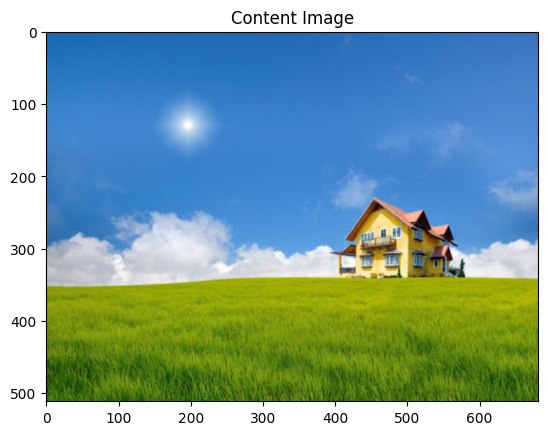

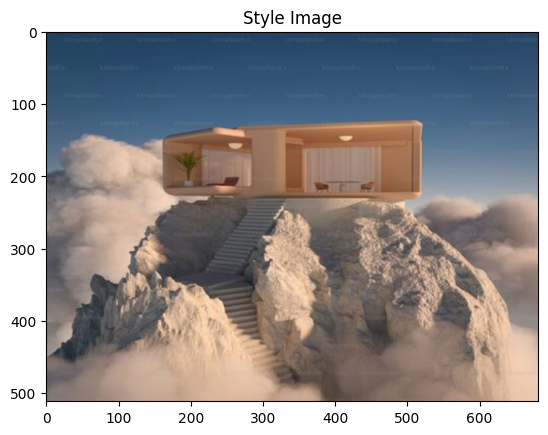

In [9]:
# Display function for images
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # clone the tensor to not modify it
    image = image.squeeze(0)      # remove batch dimension
    unloader = transforms.ToPILImage()
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(content_img, title='Content Image')

plt.figure()
imshow(style_img, title='Style Image')

In [10]:
# Define a module to normalize input images so that they have the same mean and std as VGG
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # Reshape to [C x 1 x 1] so they can directly work with image tensor
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

In [11]:
# Define Content Loss module
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        # Detach target from the tree as it is a fixed target
        self.target = target.detach()
        self.loss = 0

    def forward(self, input):
        # Compute mean squared error
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

In [12]:
# Define a function to compute the Gram matrix for style representation
def gram_matrix(input):
    batch_size, feature_maps, h, w = input.size()
    features = input.view(batch_size * feature_maps, h * w)
    G = torch.mm(features, features.t())
    return G.div(batch_size * feature_maps * h * w)


In [13]:
# Define Style Loss module
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

In [14]:
# Load the pretrained VGG19 model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG networks are trained on images with each channel normalized by these mean and std values
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std  = [0.229, 0.224, 0.225]

# Choose layers where we'll compute content and style losses
content_layers = ['conv_4']
style_layers   = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 67.5MB/s]


In [15]:
# Build the model and insert content and style loss modules at appropriate layers
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers,
                               style_layers=style_layers):
    cnn = copy.deepcopy(cnn)

    # Create a normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses   = []

    # Build a sequential model with inserted loss modules
    model = nn.Sequential(normalization)
    i = 0  # increment for conv layers
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            # Replace in-place ReLU with out-of-place version
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # Add style loss module after the selected layers
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

        # Add content loss module after the selected layers
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

    # Trim layers after the last content and style loss modules
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i+1)]

    return model, style_losses, content_losses

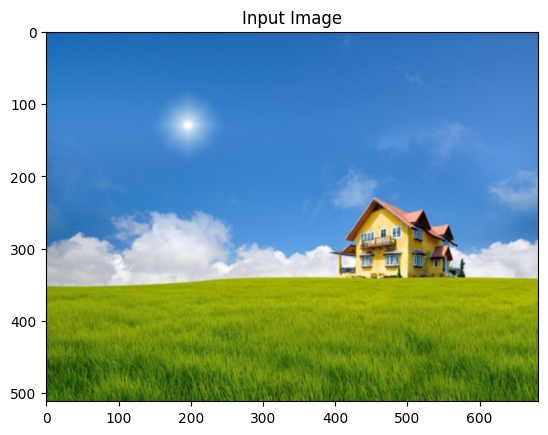

In [16]:
# Input image: starting from the content image
input_img = content_img.clone()

# Display input image
plt.figure()
imshow(input_img, title='Input Image')

# Run the style transfer
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # Correct values to be in [0,1]
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_weight * style_score + content_weight * content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("Step {}:".format(run[0]))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        optimizer.step(closure)

    # Clamp the final output
    input_img.data.clamp_(0, 1)
    return input_img

Building the style transfer model..
Optimizing..
Step 50:
Style Loss : 0.000024 Content Loss: 5.427680

Step 100:
Style Loss : 0.000005 Content Loss: 4.987791

Step 150:
Style Loss : 0.000002 Content Loss: 3.690452

Step 200:
Style Loss : 0.000001 Content Loss: 3.201857

Step 250:
Style Loss : 0.000001 Content Loss: 2.922837

Step 300:
Style Loss : 0.000001 Content Loss: 2.760978



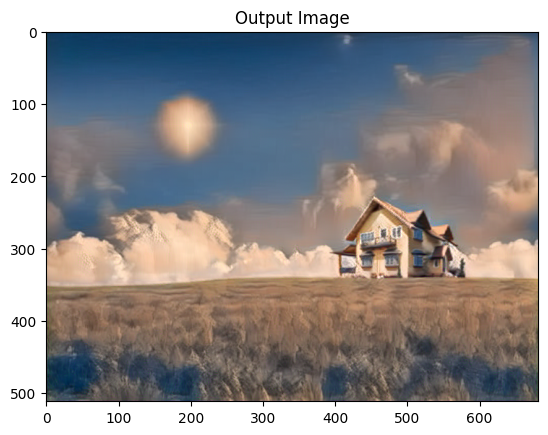

In [17]:
# Run the style transfer and get the output image
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# Display and save the final stylized image
plt.figure()
imshow(output, title='Output Image')
plt.show()

# Optionally, save the output image
unloader = transforms.ToPILImage()
image = output.cpu().clone().squeeze(0)
image = unloader(image)
image.save("output_stylized_image.jpg")